# 1. Parsing RGB-D data to create a view dataset

In this tutorial, we will parse an iPhone 13 recorded RGB-D video to create a dataset of views that we can label with the pretrained models in the next tutorial. To capture the RGB-D videos used in this tutorial, we used the Record3D app on an iPhone 13 pro, available [here](https://record3d.app/). We assume that the user has already captured an RGB-D video using the Record3D app and has the r3d file in the root directory of this repo at the `../nyu.r3d` relative path.

In [1]:
import json
from pathlib import Path
from typing import List, Optional
from zipfile import ZipFile

import liblzfse
import numpy as np
import open3d as o3d
import tqdm
from PIL import Image
from quaternion import as_rotation_matrix, quaternion
from torch.utils.data import Dataset

import sys
sys.path.append('..')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Import default class labels.
from dataloaders.scannet_200_classes import CLASS_LABELS_200

# TODO: Replace with your own path.
DATA_PATH = '../nyu.r3d'

## Creating a parser for the r3d file
The "view dataset" as we are calling it is a simple `torch` dataset. The dataset contains some meta information, such as the image size and the camera matrix, as well as information about the environment as a sequence of RGB and depth images paired with their real-world XYZ coordinates. We can also associate a set of custom text labels with this dataset as a hint to the open-label detection models that we use in the next step.

It is straightforward to create a new view dataset class with whichever format of data you may have available, the only necessary parts contains the `image_size` attribute, the `_id_to_name` attribute, and the `__getitem__` method that returns a dictionary with the following keys:

```python
{
    "rgb": torch.Tensor, # RGB image of shape (H, W, 3)
    "depth": torch.Tensor, # Depth image of shape (H, W)
    "xyz_position": torch.Tensor, # XYZ coordinates of shape (H, W, 3)
    "conf": torch.Tensor, # Confidence in the depth map, shape (H, W)
}
```

In [3]:
class R3DSemanticDataset(Dataset):
    def __init__(
        self,
        path: str,
        custom_classes: Optional[List[str]] = CLASS_LABELS_200,
    ):
        if path.endswith((".zip", ".r3d")):
            self._path = ZipFile(path)
        else:
            self._path = Path(path)

        if custom_classes:
            self._classes = custom_classes
        else:
            self._classes = CLASS_LABELS_200

        self._reshaped_depth = []
        self._reshaped_conf = []
        self._depth_images = []
        self._rgb_images = []
        self._confidences = []

        self._metadata = self._read_metadata()
        self.global_xyzs = []
        self.global_pcds = []
        self._load_data()
        self._reshape_all_depth_and_conf()
        self.calculate_all_global_xyzs()
        
        del self._path
        del self.global_pcds

    def _read_metadata(self):
        with self._path.open("metadata", "r") as f:
            metadata_dict = json.load(f)

        # Now figure out the details from the metadata dict.
        self.rgb_width = metadata_dict["w"]
        self.rgb_height = metadata_dict["h"]
        self.fps = metadata_dict["fps"]
        self.camera_matrix = np.array(metadata_dict["K"]).reshape(3, 3).T

        self.image_size = (self.rgb_width, self.rgb_height)
        self.poses = np.array(metadata_dict["poses"])
        self.init_pose = np.array(metadata_dict["initPose"])
        self.total_images = len(self.poses)

        self._id_to_name = {i: x for (i, x) in enumerate(self._classes)}

    def load_image(self, filepath):
        with self._path.open(filepath, "r") as image_file:
            return np.asarray(Image.open(image_file))

    def load_depth(self, filepath):
        with self._path.open(filepath, "r") as depth_fh:
            raw_bytes = depth_fh.read()
            decompressed_bytes = liblzfse.decompress(raw_bytes)
            depth_img: np.ndarray = np.frombuffer(decompressed_bytes, dtype=np.float32)

        if depth_img.shape[0] == 960 * 720:
            depth_img = depth_img.reshape((960, 720))  # For a FaceID camera 3D Video
        else:
            depth_img = depth_img.reshape((256, 192))  # For a LiDAR 3D Video
        return depth_img

    def load_conf(self, filepath):
        with self._path.open(filepath, "r") as depth_fh:
            raw_bytes = depth_fh.read()
            decompressed_bytes = liblzfse.decompress(raw_bytes)
            depth_img = np.frombuffer(decompressed_bytes, dtype=np.uint8)
        if depth_img.shape[0] == 960 * 720:
            depth_img = depth_img.reshape((960, 720))  # For a FaceID camera 3D Video
        else:
            depth_img = depth_img.reshape((256, 192))  # For a LiDAR 3D Video
        return depth_img

    def _load_data(self):
        assert self.fps  # Make sure metadata is read correctly first.
        for i in tqdm.trange(self.total_images, desc="Loading data"):
            # Read up the RGB and depth images first.
            rgb_filepath = f"rgbd/{i}.jpg"
            depth_filepath = f"rgbd/{i}.depth"
            conf_filepath = f"rgbd/{i}.conf"

            depth_img = self.load_depth(depth_filepath)
            confidence = self.load_conf(conf_filepath)
            rgb_img = self.load_image(rgb_filepath)

            # Now, convert depth image to real world XYZ pointcloud.
            self._depth_images.append(depth_img)
            self._rgb_images.append(rgb_img)
            self._confidences.append(confidence)

    def _reshape_all_depth_and_conf(self):
        for index in tqdm.trange(len(self.poses), desc="Upscaling depth and conf"):
            depth_image = self._depth_images[index]
            # Upscale depth image.
            pil_img = Image.fromarray(depth_image)
            reshaped_img = pil_img.resize((self.rgb_width, self.rgb_height))
            reshaped_img = np.asarray(reshaped_img)
            self._reshaped_depth.append(reshaped_img)

            # Upscale confidence as well
            confidence = self._confidences[index]
            conf_img = Image.fromarray(confidence)
            reshaped_conf = conf_img.resize((self.rgb_width, self.rgb_height))
            reshaped_conf = np.asarray(reshaped_conf)
            self._reshaped_conf.append(reshaped_conf)

    def get_global_xyz(self, index, depth_scale=1000.0, only_confident=True):
        reshaped_img = np.copy(self._reshaped_depth[index])
        # If only confident, replace not confident points with nans
        if only_confident:
            reshaped_img[self._reshaped_conf[index] != 2] = np.nan

        depth_o3d = o3d.geometry.Image(
            np.ascontiguousarray(depth_scale * reshaped_img).astype(np.float32)
        )
        rgb_o3d = o3d.geometry.Image(
            np.ascontiguousarray(self._rgb_images[index]).astype(np.uint8)
        )

        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            rgb_o3d, depth_o3d, convert_rgb_to_intensity=False
        )

        camera_intrinsics = o3d.camera.PinholeCameraIntrinsic(
            width=int(self.rgb_width),
            height=int(self.rgb_height),
            fx=self.camera_matrix[0, 0],
            fy=self.camera_matrix[1, 1],
            cx=self.camera_matrix[0, 2],
            cy=self.camera_matrix[1, 2],
        )
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
            rgbd_image, camera_intrinsics
        )
        # Flip the pcd
        pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

        extrinsic_matrix = np.eye(4)
        qx, qy, qz, qw, px, py, pz = self.poses[index]
        extrinsic_matrix[:3, :3] = as_rotation_matrix(quaternion(qw, qx, qy, qz))
        extrinsic_matrix[:3, -1] = [px, py, pz]
        pcd.transform(extrinsic_matrix)

        # Now transform everything by init pose.
        init_matrix = np.eye(4)
        qx, qy, qz, qw, px, py, pz = self.init_pose
        init_matrix[:3, :3] = as_rotation_matrix(quaternion(qw, qx, qy, qz))
        init_matrix[:3, -1] = [px, py, pz]
        pcd.transform(init_matrix)

        return pcd

    def calculate_all_global_xyzs(self, only_confident=True):
        if len(self.global_xyzs):
            return self.global_xyzs, self.global_pcds
        for i in tqdm.trange(len(self.poses), desc="Calculating global XYZs"):
            global_xyz_pcd = self.get_global_xyz(i, only_confident=only_confident)
            global_xyz = np.asarray(global_xyz_pcd.points)
            self.global_xyzs.append(global_xyz)
            self.global_pcds.append(global_xyz_pcd)
        return self.global_xyzs, self.global_pcds

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        result = {
            "xyz_position": self.global_xyzs[idx],
            "rgb": self._rgb_images[idx],
            "depth": self._reshaped_depth[idx],
            "conf": self._reshaped_conf[idx],
        }
        return result


## Creating the view dataset

Now that we have defined a parser for the `r3d` file, we will process our data to create a view dataset. As we can see above, we can associate a set of custom labels with our view dataset if we want to.

In [4]:
CUSTOM_LABELS = [
    "kitchen counter",
    "kitchen cabinet",
    "stove",
    "cabinet",
    "bathroom counter",
    "refrigerator",
    "microwave",
    "oven",
    "fireplace",
    "door",
    "sink",
    "furniture",
    "dish rack",
    "dining table",
    "shelf",
    "bar",
    "dishwasher",
    "toaster oven",
    "toaster",
    "mini fridge",
    "soap dish",
    "coffee maker",
    "table",
    "bowl",
    "rack",
    "bulletin board",
    "water cooler",
    "coffee kettle",
    "lamp",
    "plate",
    "window",
    "dustpan",
    "trash bin",
    "ceiling",
    "doorframe",
    "trash can",
    "basket",
    "wall",
    "bottle",
    "broom",
    "bin",
    "paper",
    "storage container",
    "box",
    "tray",
    "whiteboard",
    "decoration",
    "board",
    "cup",
    "windowsill",
    "potted plant",
    "light",
    "machine",
    "fire extinguisher",
    "bag",
    "paper towel roll",
    "chair",
    "book",
    "fire alarm",
    "blinds",
    "crate",
    "tissue box",
    "towel",
    "paper bag",
    "column",
    "fan",
    "object",
    "range hood",
    "plant",
    "structure",
    "poster",
    "mat",
    "water bottle",
    "power outlet",
    "storage bin",
    "radiator",
    "picture",
    "water pitcher",
    "pillar",
    "light switch",
    "bucket",
    "storage organizer",
    "vent",
    "counter",
    "ceiling light",
    "case of water bottles",
    "pipe",
    "scale",
    "recycling bin",
    "clock",
    "sign",
    "folded chair",
    "power strip",
]

In [5]:
dataset = R3DSemanticDataset(DATA_PATH, CUSTOM_LABELS)

Calculating global XYZs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [00:13<00:00, 55.83it/s]


## Visualizing the results

We can also visualize the parsed R3D file's contents.

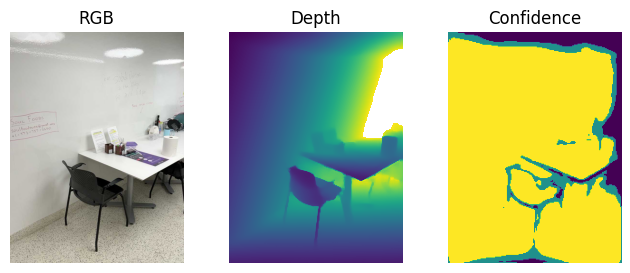

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(8, 3))

titles = ["RGB", "Depth", "Confidence"]
for ax, data, title in zip(axes, (dataset._rgb_images[0], dataset._depth_images[0], dataset._confidences[0]), titles):
    ax.imshow(data)
    ax.axis("off")
    ax.set_title(title)


Finally, we save our parsed R3D file to use in the next step of our process, which is to label them.

In [7]:
import torch

torch.save(dataset, '../nyu_views.pth')